# Muon-Decay-Acquire

## The following cell acquires and plots a triggered single-pulse or double-pulse signal with Python.


We use the *periphery module*. Program the FPGA with the command *cat Muon-Decay.bit > /dev/xdevcfg*

Trigger occurs at the falling edge.

NUM SINGE-PULSES =  36  NUM DOUBLE-PULSES =  12
Pointer at trigger=  617  = 0x269


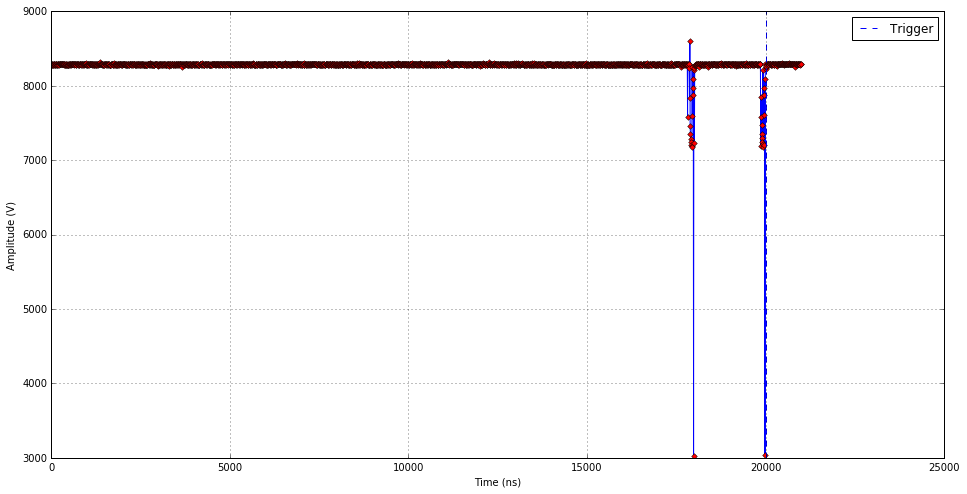

In [26]:
#!/usr/bin/python
###################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD = 7800 # Volt
POINTS_SAVE_AFTER_TRIGGER = 1000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns


WIDTH = 80 # ns
DELTA_TIME = 2000 # ns
MODE = 1  # # MODE = 0 SINGLE  MODE = 1 DOUBLE
###################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE

from periphery import MMIO
import numpy as np

regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE


############################################# RESET COUNTERS ######################
#regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
#regset.write32(8,2 + MODE)     # RESET COUNTERS
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()

    
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD*256*256) # TRESHOLD 

ADDR_TRIG_OLD = int(regset.read32(8)/256/256)
regset.write32(0,TRESHOLD*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD*256*256)
regset.close()


###################DOUBLE PULSE GENERATOR ##########################

WIDTH = int (WIDTH/8) 
DELTA_TIME = int (DELTA_TIME/8)
regset = MMIO(0x41210000, 0xc)
regset.write32(0,DELTA_TIME*256*256+WIDTH*16) 
regset.write32(0,DELTA_TIME*256*256+WIDTH*16+1) 
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()
####################################################################

regset = MMIO(0x41200000, 0xc)

while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256)
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-POINTS_BEFORE_TRIGGER,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD*256*256+ADDR_B*16+1)
    regset.write32(0,TRESHOLD*256*256+ADDR_B*16)
    COUNTS = regset.read32(8)%(256*256)
    #if (counts < 2**13):
    #    DATA_VOLT = GAIN*(counts+1)/2**13 
    #if (counts >= 2**13):
    #    DATA_VOLT =  GAIN*((counts-2**13)/2**13 -1)
    #dat.append(DATA_VOLT)
    #if (n%2 == 0):
        #print (n," ",counts,"=",hex(counts),end=" ")

    #DATA_VOLT = GAIN*(2*(counts)/2**14  -1)

    #dat.append(DATA_VOLT)
    #dat.append((2**14/2-counts)/2**13*GAIN)
    dat.append(COUNTS)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = POINTS_BEFORE_TRIGGER*8, color='b', ls='--', lw=1, label='Trigger')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()

plt.show()
regset.close()

## Here we read and plot the same sampled data with different parameters

Pointer at trigger=  617  = 0x269


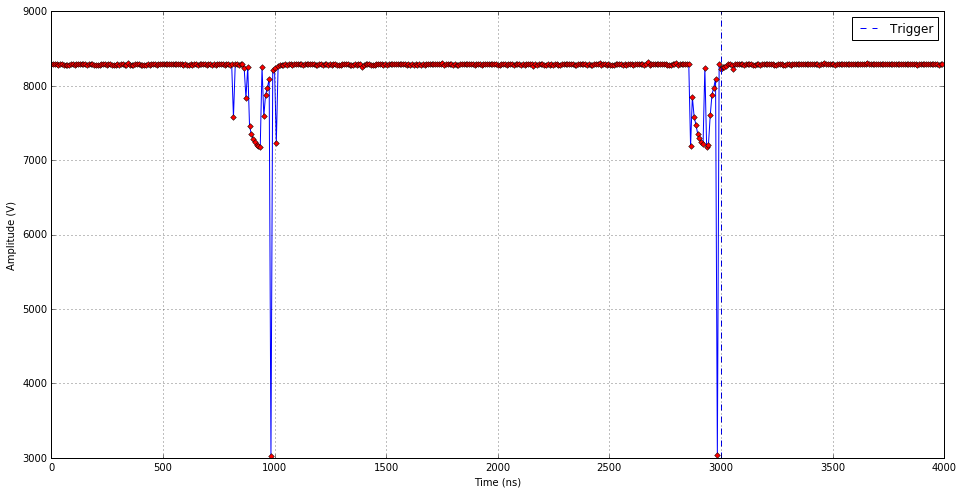

In [29]:
POINTS_SAVE_AFTER_TRIGGER = 1000 # ns
POINTS_BEFORE_TRIGGER = 3000 # ns
####################################################################
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_BEFORE_TRIGGER = int(POINTS_BEFORE_TRIGGER/8)
from periphery import MMIO
import numpy as np

regset = MMIO(0x41200000, 0xc)


print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-POINTS_BEFORE_TRIGGER,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD*256*256+ADDR_B*16+1)
    regset.write32(0,TRESHOLD*256*256+ADDR_B*16)
    COUNTS = regset.read32(8)%(256*256)
    #if (counts < 2**13):
    #    DATA_VOLT = GAIN*(counts+1)/2**13 
    #if (counts >= 2**13):
    #    DATA_VOLT =  GAIN*((counts-2**13)/2**13 -1)
    #dat.append(DATA_VOLT)
    #if (n%2 == 0):
        #print (n," ",counts,"=",hex(counts),end=" ")

    #DATA_VOLT = GAIN*(2*(counts)/2**14  -1)

    #dat.append(DATA_VOLT)
    #dat.append((2**14/2-counts)/2**13*GAIN)
    dat.append(COUNTS)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = POINTS_BEFORE_TRIGGER*8, color='b', ls='--', lw=1, label='Trigger')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()

plt.show()
regset.close()